In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import scipy as sp
import matplotlib.pyplot as plt


###################################
#### Sparse approach
###################################
def theta(x_arr):
    return (x_arr>=0.5)



def fill_max_sparse_1(input_size):
    max_arr = -np.array([[1, -1], [0, 1], [0, -1]])
    iden = sp.sparse.eye(input_size)
    max_sparse = sp.sparse.bsr_matrix(max_arr)
    matrix = sp.sparse.kron(iden, max_sparse)
    # matrix = np.kron(np.eye(input_size),max_arr)
    # matrix = sp.sparse.bsr_matrix(matrix)
    return matrix.T


def fill_max_sparse_2(input_size):
    array = -sp.sparse.bsr_matrix([1, 1, -1])
    iden = sp.sparse.eye(input_size)
    matrix = np.kron(np.eye(input_size), array)
    matrix = sp.sparse.kron(iden, array)
    return matrix.T


def para_sparse_matrices(*arg):
    result = []
    for mat in zip(*arg):
        sat = sp.sparse.block_diag(mat)
        result.append(sat)
    return result


def shape_to_model(dense_matrix, activ ="relu",train=True):
    shape_list = [a.shape for a in dense_matrix]
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(int(shap[0])))
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    model_matrix.set_weights(mat_init)
    return model_matrix




def shape_to_random_model(dense_matrix, activ ="relu",train=True):
    shape_list = [a.shape for a in dense_matrix]
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(int(shap[0])))
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    # mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    # model_matrix.set_weights(mat_init)
    return model_matrix


def set_up_max_matrix(depth):
    result = []
    while depth != 0:
        result.append(fill_max_sparse_1(depth))
        result.append(fill_max_sparse_2(depth))
        depth = int(depth / 2)
    return result



def fill_min_sparse_1(input_size):
  max_arr = np.array([[-1,1],[0,-1],[0,1]])
  iden = sp.sparse.eye(input_size)
  max_sparse = sp.sparse.bsr_matrix(max_arr)
  matrix = sp.sparse.kron(iden,max_sparse)
  return matrix.T

def fill_min_sparse_2(input_size):
  array = sp.sparse.bsr_matrix([-1,-1,1])
  iden = sp.sparse.eye(input_size)
  matrix = np.kron(np.eye(input_size), array)
  matrix = sp.sparse.kron(iden,array)
  return matrix.T

def set_up_min_matrix(depth):
  result = []
  while depth != 0:
    result.append(fill_min_sparse_1(depth))
    result.append(fill_min_sparse_2(depth))
    depth = int(depth/2)
  return result


def invert_matrix(point_list):
    ones = np.ones((point_list.shape[0],1))
    point_list = np.concatenate((point_list,ones) , axis=1)
    zeros = np.zeros((point_list.shape[0]))
    zeros[0] = 1
    solution = np.linalg.inv(point_list)@zeros
    return solution

def RAI(shape, dtype=None):
  fan_in,fan_out = shape
  """Randomized asymmetric initializer.
  6 It draws samples using RAI where fan_in is the number of input units in the weight
  tensor and fan_out is the number of output units in the weight tensor.
  7 """
  V = np.random.randn(fan_out, fan_in + 1) * 0.6007 / fan_in ** 0.5
  for j in range(fan_out):
    k = np.random.randint(0, high=fan_in + 1)
    V[j, k] = np.random.beta(2, 1)
    W = V[:, :-1].T
    b = V[:, -1]
  return W.astype(np.float32), b.astype(np.float32)

In [ ]:
point_invert = np.array([[1],[2]])
print(invert_matrix(point_invert))

[-1.  2.]


In [ ]:
xmin=0
xmax=1

NN = 7

x = np.linspace(0,1,NN)
grid = np.meshgrid(x,x)

X, Y = np.mgrid[xmin:xmax:3j, xmin:xmax:3j]
positions = np.vstack([X.ravel(), Y.ravel()])

positions = positions.T
dim = positions.shape[0]
ones = np.linspace(0,dim-1,dim).astype(int)

res = pd.DataFrame(x)
#res = np.column_stack([ones.T,positions])

print(res.head())
print(1/(NN-1))

## generate the nearest neighbours
pat_1dn = res
pat_1dn.columns=['point']
#print(res.shift(periods=-1))
#pat_1dn['prev'] = (pat_1dn.index -1).astype(int) 
pat_1dn['prev'] = pat_1dn.point - 1/(NN-1)
pat_1dn['next'] = pat_1dn.point + 1/(NN-1)
#pat_1dn['next'] = (pat_1dn.index +1).astype(int) 
print(pat_1dn)
#pat_1dn['next'] = res.shift(periods= -1).values

res['glob_linp'] = [invert_matrix(np.array([[a],[b]])) for a,b in zip(pat_1dn.point,pat_1dn.prev) ]
res['glob_linn'] = [invert_matrix(np.array([[a],[b]])) for a,b in zip(pat_1dn.point,pat_1dn.next) ]
global_lin = res[['glob_linp','glob_linn']]

stacked_tf =[tf.convert_to_tensor(aa) for aa in global_lin.stack().values]
print(stacked_tf)
print(x)

          0
0  0.000000
1  0.166667
2  0.333333
3  0.500000
4  0.666667
0.16666666666666666
      point      prev      next
0  0.000000 -0.166667  0.166667
1  0.166667  0.000000  0.333333
2  0.333333  0.166667  0.500000
3  0.500000  0.333333  0.666667
4  0.666667  0.500000  0.833333
5  0.833333  0.666667  1.000000
6  1.000000  0.833333  1.166667
[<tf.Tensor: shape=(2,), dtype=float64, numpy=array([6., 1.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-6.,  1.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([6., 0.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-6.,  2.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 6., -1.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-6.,  3.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 6., -2.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-6.,  4.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 6., -3.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-6.,  5.])>, <tf.T

In [ ]:
oner = False

def boundary(y):
  if oner:
    ret = np.ones_like(y)
  else:
    ret = (y*(1-y))**1
  return ret#(y*(1-y))**1 ## #

def boundary_arr(y):
  return np.array([1/a if a!=0 else 1 for a in boundary(y)],dtype=object)

def func_approx(x_len):
  return np.sin(1*np.pi*x_len) /(1*np.pi)  *boundary_arr(x_len) #(x*(1-x))**0.5 ##/ bounds # 


def shape_to_model_glob_lin(activ ="relu",train=True):
    minimum_list = set_up_min_matrix(1)
    dense_matrix = para_sparse_matrices(*[ minimum_list for i in range(NN)])
    shape_list = [a.shape for a in dense_matrix]
    stack_array = np.array(stacked_tf)
    print(shape_list)
    reg = tf.keras.regularizers.l1(l1=0.01)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(1))
            net = layers.Dense(shap[0], activation=activ, bias_initializer='zeros', trainable=True, kernel_regularizer
                               =reg, bias_regularizer =reg )(input_mat)
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train, kernel_regularizer
                               =reg, bias_regularizer =reg )(net)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train, kernel_regularizer
                               =reg, bias_regularizer =reg )(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    n_loc = stack_array.shape[0]
    print(n_loc)
    mat_init.insert(0,stack_array.T[-1,:].reshape(n_loc,))
    mat_init.insert(0,stack_array.T[0:-1,:].reshape(1,n_loc))
    model_matrix.set_weights(mat_init)
    new_model = tf.keras.Sequential()
    new_model.add(model_matrix)
    new_model.add(layers.Dense(1,use_bias=True))
    new_model.compile()
    coefficients = func_approx(x).reshape(NN,1)
    if not oner:
      coefficients[0] = coefficients[1]
      coefficients[-1] = coefficients[-2]
    new_model.layers[-1].set_weights([coefficients,np.array([0])])
    # new_model.layers[-1].set_weights([new_df['Values'].values.reshape(9,1),np.array([0])])
    return new_model


def flattened_model(depth,width,activ='relu'):
  for i in range(depth):
    # print(i)
    if i == 0:
      input_mat = tf.keras.Input(shape=(1))
    elif i==1:
      net = layers.Dense(width, activation=activ)(input_mat) #, bias_initializer='zeros',kernel_initializer='zeros'
    elif i==depth-1:
      net_end = layers.Dense(1, activation=activ)(net)
    else:
      net = layers.Dense(width, activation=activ)(net)
  model_matrix = tf.keras.Model(input_mat, net_end)
  return model_matrix


def random_to_model_glob_lin(activ ="relu",train=True):
    minimum_list = set_up_min_matrix(1)
    dense_matrix = para_sparse_matrices(*[minimum_list for i in range(NN)])
    shape_list = [a.shape for a in dense_matrix]
    stack_array = np.array(stacked_tf)
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(1))
            net = layers.Dense(shap[0], activation=activ, bias_initializer='zeros', trainable=True)(input_mat)
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    new_model = tf.keras.Sequential()
    new_model.add(model_matrix)
    new_model.add(layers.Dense(1))
    #new_model.layers[-1].set_weights([func_approx(x), np.array([0])])
    #print(func_approx(x))
    new_model.compile()
    return new_model    

model_one_last = shape_to_model_glob_lin(train=True)

#for i in range(NN):#
#  print(i)
#model_one_last.summary()

[(14, 21), (21, 7)]
14


In [ ]:
random_model= random_to_model_glob_lin(activ='relu')
#random_model.summary()

[(40, 60), (60, 20)]


In [ ]:
#net_2 = tf.keras.Input(shape=(1))
#net_22 = layers.Dense(25, activation='relu', bias_initializer='zeros',kernel_initializer='zeros')(net_2)
#net_222 = layers.Dense(1, activation='relu', bias_initializer='zeros',kernel_initializer='zeros')(net_22)


#model_flat = tf.keras.Model(net_2, net_222)

model_ad = flattened_model(5,60,activ='tanh') ### (15,30,60  ) #TODO: tanh activ
#model_flat.summary()#$3.842e-1$$3.842e-1$

In [ ]:
domain = np.linspace(0,1,200).reshape((200,1))
model_flat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-5),
              loss=tf.keras.losses.MAE)
hist = model_flat.fit(domain,model_one_last(domain),epochs=1000)

Variational Loss: 0 1.7329591310228838
True loss 0.0023985128208726617
Variational Loss: 100 1.7655659006090951
True loss 0.0023985128208726617
Variational Loss: 200 1.8002968116617644
True loss 0.0023985128208726617
Variational Loss: 300 1.8434097573306345
True loss 0.0023985128208726617
Variational Loss: 400 1.8965212187269387
True loss 0.0023985128208726617
Variational Loss: 500 1.9554631061655046
True loss 0.0023985128208726617
Variational Loss: 600 1.9876856304539638
True loss 0.0023985128208726617
Variational Loss: 700 1.9914219388697696
True loss 0.0023985128208726617
Variational Loss: 800 1.9941417482372776
True loss 0.0023985128208726617
Variational Loss: 900 1.9962105908816377
True loss 0.0023985128208726617
Variational Loss: 1000 1.9978446166623283
True loss 0.0023985128208726617
Variational Loss: 1100 1.999177787265632
True loss 0.0023985128208726617
Variational Loss: 1200 2.0003522013273343
True loss 0.0023985128208726617
Variational Loss: 1300 2.0015325041996546
True loss

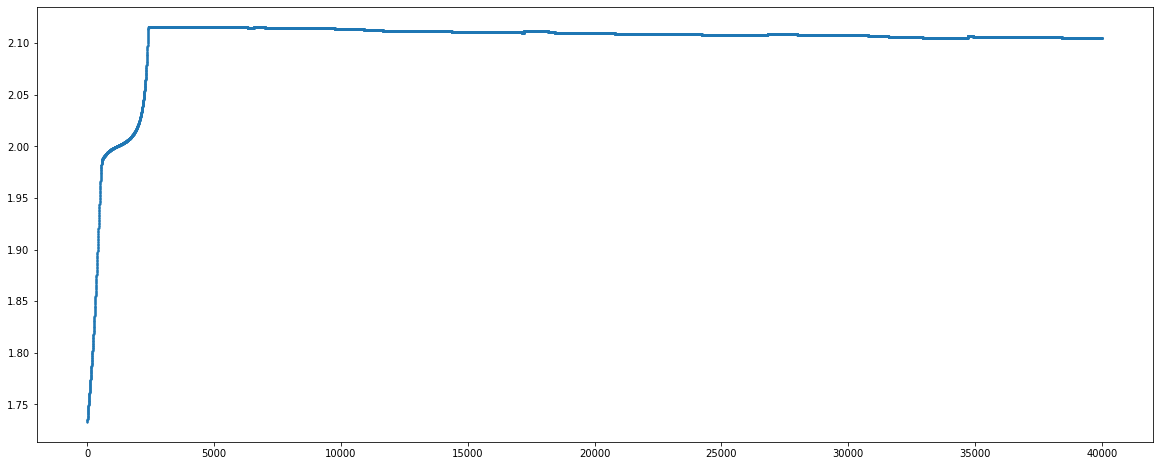

In [ ]:

domain = np.linspace(0,1,200).reshape((200,1))
domain = np.concatenate([domain,np.ones_like(domain)],axis=1)
#z = np.ones_like(x_len)# np.array(np.sin(np.pi*x_len),dtype=float)
func_train = np.sin(np.pi*domain)*np.pi

def train_model_full(model_train, Num=2000,train_steps=1500):
    x_arr = []
    err_arr = []
    true_err = []
    x_len = np.linspace(0,1,Num).reshape((Num,1))
    #z = np.ones_like(x_len)# np.array(np.sin(np.pi*x_len),dtype=float)
    z = np.sin(1*np.pi*x_len)*np.pi*1
    z_result = np.sin(1*np.pi*x_len) /(1*np.pi)#func_approx(x_len)#np.sin(np.pi*x_len)/np.pi ##x(1-x)^^0.5
    #print(z)
    #bounds = boundary(x_len).reshape((N,1))
    x_tensor = tf.convert_to_tensor(x_len, dtype=tf.float64)
    loss_min = 10
    bounds = boundary(x_tensor)#.reshape((Num,1))
    bounds = tf.convert_to_tensor(bounds, dtype=tf.float64)
    for step in range(0,train_steps):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_tensor)
            tape.watch(bounds)
            output = model_train(x_tensor, training=True)
            adver = model_ad(x_tensor,training=True)
            adver = tf.cast(adver,dtype=tf.float64)
            ad_x = tape.gradient(adver,x_tensor)
            ad_xx = tape.gradient(ad_x,x_tensor)
            #tape.watch(bounds)
            #plt.plot(x_len,z-output)
            #z = tf.reshape(z, [-1])
            output = tf.cast(output,dtype=tf.float64)
            #plt.plot(x_tensor,output)
            output = tf.reshape(output,shape=(Num,1))* bounds
            #plt.plot(x_tensor,output)
            y_x = tape.gradient(output,x_tensor)
            z = tf.reshape(z,shape=(Num,1)) 
            # energy pot and en
            #print(y_x.shape,ad_x.shape,z.shape)
            #break
            kin = tf.reduce_sum(y_x*ad_x, axis=1)
            kin = tf.reshape(kin,shape=(Num,1)) 
            pot = tf.multiply( z,adver)
            #print(kin.shape,pot.shape)
            #break
            # the bare energy loss
            #print(output[0],output[-1])
            #break
            #loss = tf.reduce_mean( tf.math.square(y_xx + z) + 100*tf.math.square(output[0]) + 100*tf.math.square(output[-1]))
            ############################**
            # Old loss
            loss = tf.reduce_mean(input_tensor=tf.math.abs(kin-pot))/tf.reduce_mean(adver**2)**0.5
            # with boundary conditions as loss
            #loss = loss #+ 20.0*output[0]**2 + 20.0*output[-1]**2
            #true_loss = tf.redu
            true_loss = tf.reduce_mean( tf.square(z_result - output) )**0.5
            if step < 4000:
              optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6) #3e-6:full  1e-5   0.000003 2e-6 for tanh
              grads_ad = tape.gradient(-loss, model_ad.trainable_weights)
              optimizer.apply_gradients((grad,var) for (grad,var) in  zip(grads_ad, model_ad.trainable_weights)) # grad is not None
            else:
              if  step%2 == 0:
                optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8) #3e-6:full  1e-5   0.000003 2e-6 for tanh
                grads_d = tape.gradient(loss, model_train.trainable_weights)
                optimizer.apply_gradients((grad,var) for (grad,var) in  zip(grads_d, model_train.trainable_weights)if grad is not None)
              else:
                optimizer = tf.keras.optimizers.Adam(learning_rate=2e-8) #3e-6:full  1e-5   0.000003 2e-6 for tanh
                #loss =  -loss
                grads_ad = tape.gradient(-loss, model_ad.trainable_weights)
                optimizer.apply_gradients((grad,var) for (grad,var) in  zip(grads_ad, model_ad.trainable_weights)if grad is not None) # grad is not None
                
        if step % 100 == 0:
            print(
                "Variational Loss:",
                step, float(loss)
            )
            print('True loss', float(true_loss))
            # print("reduced loss:", float(loss_direct))
        x_arr.append(step)
        err_arr.append(float(loss))
        true_err.append(true_loss)
    #print('error:', (loss_first))
    #print('error min:', float(loss_min+0.25))
    plt.figure(figsize=(20,8))
    plt.scatter(x_arr,err_arr,s=1)
    #plt.yscale('log')
    return x_arr,err_arr,true_err
#5 -> 4300
#$1.780$ -> 4600
#$$3.842e-1$->> 2700
#hist = model_one_last.fit(domain, func_train,epochs=80000,verbose=0)   
x_cont,y_cont,t_err = train_model_full(model_one_last,train_steps=40000)

In [ ]:
print(model_flat.get_weights())

In [ ]:
#print(y_r_rel[::-1])
f, (ax1, ax2) = plt.subplots(1, 2,sharex=True) #plt.figure())
f.set_figheight(15)
f.set_figwidth(15)
# print((y))
#plt.plot(x_step,y_err) 
#plt.scatter(x_step55,y_err55,s=1,label='First and Last',marker='x')
#plt.plot(x_cont_all,y_cont_all, label='random flat boundary')
ax1.plot(x_cont,y_cont+np.ones_like(y_cont)*2.6, label='1 hidden layer relu + offset')
ax2.plot(x_cont,t_err, label='true L2 error')
#plt.plot(x_s_relu,y_s_relu, label='ReLU')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(-1,3000)
plt.xlabel('Ierations', fontsize=30)
plt.ylabel('Energy and MAE', fontsize=30)
plt.legend() #fontsize=30

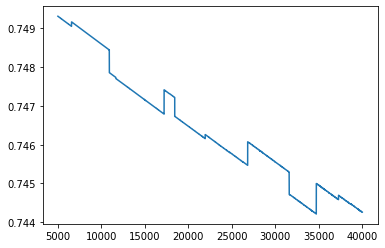

In [ ]:
plt.plot(x_cont[5000:], np.log(y_cont[5000:]))

Text(0.5, 1.0, 'VPINN and MSE for CPWL Init with boundary function')

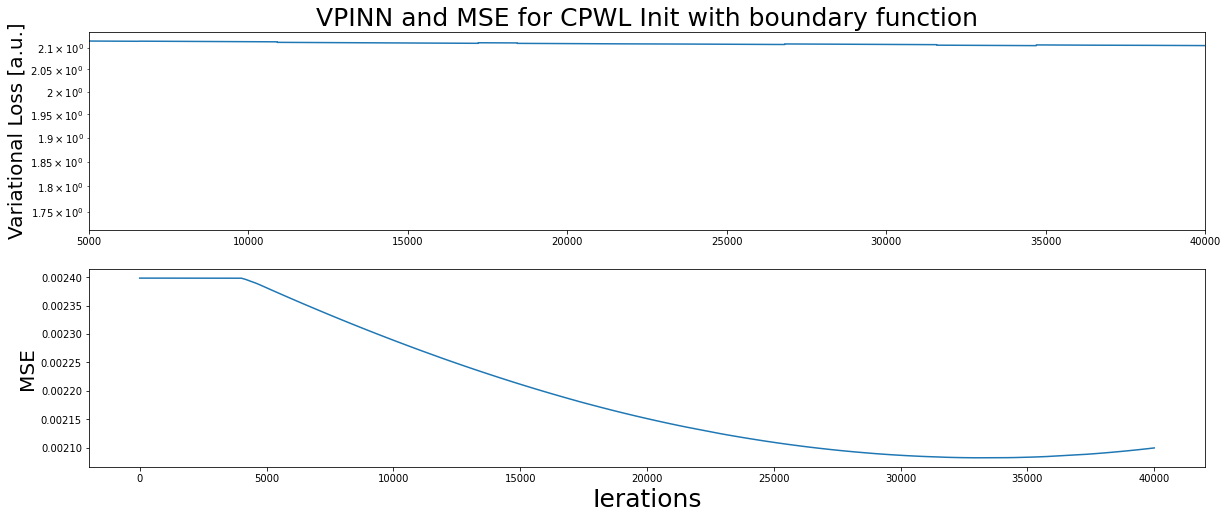

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(x_cont,y_cont, label='1 hidden layer relu + offset')
ax2.plot(x_cont,t_err, label='true L2 error')


# Set common labels
ax.set_xlabel('Ierations', fontsize=25)
ax1.set_xlim(5000,40000)
ax1.set_yscale('log')
#ax2.set_xlim(-1,1000)
#ax.set_ylabel('Energy and MAE', fontsize=30)

ax2.set_ylabel('MSE', fontsize=20)
ax1.set_ylabel('Variational Loss [a.u.]', fontsize=20)
ax.set_title('VPINN and MSE for CPWL Init with boundary function', fontsize=25)
#ax1.set_yscale('log')
#ax1.set_title('ax1 title')
#ax2.set_title('ax2 title')

#plt.savefig('common_labels.png', dpi=300)

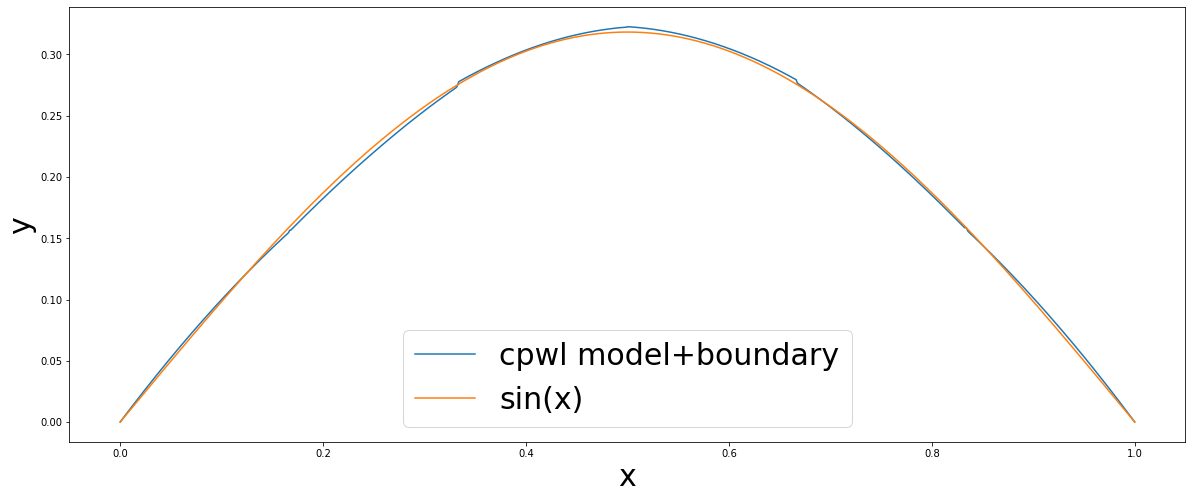

(<Figure size 1440x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f049421e950>)

In [ ]:
def plot_decision_boundary_full(model_plot, steps=2000, cmap='Paired'):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot()#projection='3d'
    x_span = np.linspace(0, 1, steps)
    # print(len(x_span))
    test = np.c_[x_span, np.ones(steps)]
    func_values = model_plot.predict(x_span)*boundary(x_span).reshape(steps,1)
    # m = np.max(np.abs(func_values))
    #z = func_values.reshape(xx.shape)*boundary(xx,yy)
    zz = func_approx(x_span)*boundary(x_span) #np.sin(np.pi*x_span)/(np.pi)#*np.sin(np.pi*yy)/(2*np.pi)# *boundary
    #ax = fig.add_subplot(projection='3d')
    ax.plot(x_span, func_values, label='cpwl model+boundary')
    ax.plot(x_span,zz,label='sin(x)')
    plt.xlabel('x', fontsize=30)
    plt.ylabel('y', fontsize=30)
    plt.legend(fontsize=30)
    # ax.plot(x_span,zz*m)
    #ax.contourf(xx, yy, z, alpha=0.7,cmap=plt.cm.rainbow)
    #plt.colorbar(PCM,ax=ax)
    #plt.imshow
    plt.show()
    # plt.savefig("fem_trained.png")
    return fig, ax

plot_decision_boundary_full(model_one_last)

#model_one_last([[0.5,1]])

In [ ]:
N=10000
x_len = np.linspace(0,1,N).reshape((N,1))
#z = np.ones_like(x_len)# np.array(np.sin(np.pi*x_len),dtype=float)
z = np.sin(np.pi*x_len)/np.pi
nn_list = []
err_list = []
for NN in range(3,200):
  nn_list.append(NN)
  x = np.linspace(0,1,NN)
  res = pd.DataFrame(x)
  pat_1dn = res
  pat_1dn.columns=['point']
  pat_1dn['prev'] = pat_1dn.point - 1/(NN-1)
  pat_1dn['next'] = pat_1dn.point + 1/(NN-1)
  res['glob_linp'] = [invert_matrix(np.array([[a],[b]])) for a,b in zip(pat_1dn.point,pat_1dn.prev) ]
  res['glob_linn'] = [invert_matrix(np.array([[a],[b]])) for a,b in zip(pat_1dn.point,pat_1dn.next) ]
  global_lin = res[['glob_linp','glob_linn']]
  stacked_tf =[tf.convert_to_tensor(aa) for aa in global_lin.stack().values]
  def shape_to_model_glob_lin_loop(activ ="relu",train=True):
    minimum_list = set_up_min_matrix(1)
    dense_matrix = para_sparse_matrices(*[ minimum_list for i in range(NN)])
    shape_list = [a.shape for a in dense_matrix]
    stack_array = np.array(stacked_tf)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(2))
            net = layers.Dense(shap[0], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    mat_init.insert(0,np.zeros(stack_array.shape[0]))
    mat_init.insert(0,stack_array.T)
    model_matrix.set_weights(mat_init)
    new_model = tf.keras.Sequential()
    new_model.add(model_matrix)
    new_model.add(layers.Dense(1))
    new_model.compile()
    new_model.layers[-1].set_weights([func_approx(x).reshape(NN,1), np.array([0])])
    return new_model
  model_one_last_loop = shape_to_model_glob_lin_loop(train=False)
  test = np.c_[x_len, np.ones(x_len.shape[0])]
  func_values = model_one_last_loop.predict(test)
  err = np.mean((func_values-z)**2)
  err_list.append(err)

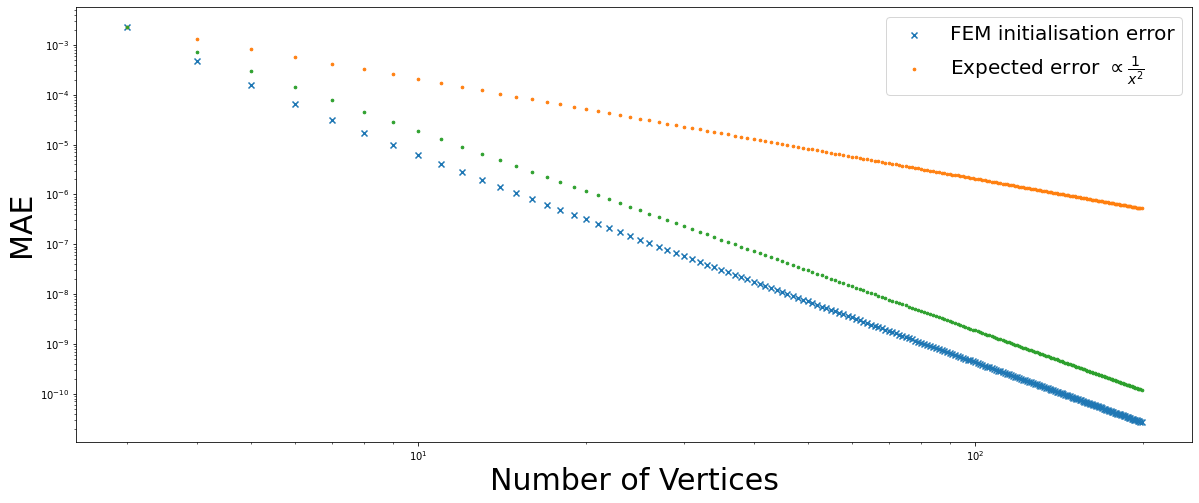

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(nn_list,err_list,marker='x')
plt.scatter(np.array(nn_list),err_list[0]*9/np.array(nn_list)**2, s=7)
plt.scatter(np.array(nn_list),err_list[0]*3**4/np.array(nn_list)**4, s=7)
#plt.scatter(np.array(nn_list),0.0002/np.array(nn_list)**3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Vertices', fontsize=30)
plt.ylabel('MAE', fontsize=30)
plt.legend(['FEM initialisation error',r"Expected error $\propto \frac{1}{x^{2}}$"], fontsize=20)

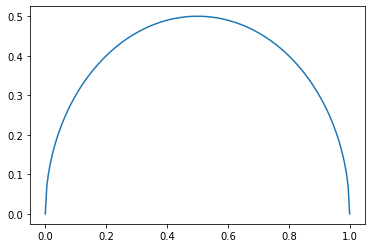

In [ ]:
plt.plot(domain, (domain*(1-domain))**0.5)